In [113]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [114]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#OPTION for when using google colab files
from google.colab import files
path_to_file = list(files.upload().keys())[0]

In [ ]:
#OPTION to import your own files, However this only works with Chrome
path_to_file = tf.keras.utils.get_file('cleaner_script.txt', '/content/cleaner_script.txt')

In [118]:
#OPTION after linking with google drive, or uploading to google (temporary)
#path_to_file = '/content/cleaner_script.txt'
path_to_file = '/content/gdrive/My Drive/Summer Challenge Project/Today is Forever/cleaner_script.txt'
#Due to issue with using Safari, we uploaded the text file into google colab workspace

In [119]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 319880 characters


In [120]:
# Take a look at the first 250 characters in text
print(text[:250])

A Manikin must have stolen it and fled, in hopes of returning to the Vortex World. 
A big group of Manikins went downstairs. 
A bunch of Mantra demons came through here on their way to fight Nihilo. 
A buncha Manikins just walked right in there! 
A b


In [121]:
vocab = sorted(set(text))
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[c] for c in text])

text_as_int = text_to_int(text)

In [ ]:
# lets look at how part of our text is encoded
print("Text:", text[:13])
print("Encoded:", text_to_int(text[:13]))

Text: A Manikin mus
Encoded: [22  2 34 47 60 55 57 55 60  2 59 67 65]


In [122]:
def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

print(int_to_text(text_as_int[:13]))

A Manikin mus


we need to split our text data from above into many shorter sequences that we can pass to the model as training examples.
The training examples we will prepapre will use a seq_length sequence as input and a seq_length sequence as the output where that sequence is the original sequence shifted one letter to the right. For example:
input: Hell | output: ello

In [123]:
seq_length = 70  # length of sequence for a training example default is 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

- NOTE: Because this resembles a Markov Chain method of generating text, (by character, instead of by word) I have my doubts in pusuing this method

In [124]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
#when we run out of letters, we drop the rest

In [125]:
def split_input_target(chunk):  # for the example: hello
    input_text = chunk[:-1]  # hell
    target_text = chunk[1:]  # ello
    return input_text, target_text  # hell, ello

dataset = sequences.map(split_input_target)  # we use map to apply the above function to every entry

In [ ]:
for x, y in dataset.take(2):
  print("\n\nEXAMPLE\n")
  print("INPUT")
  print(int_to_text(x))
  print("\nOUTPUT")
  print(int_to_text(y))



EXAMPLE

INPUT
A Manikin must have 

OUTPUT
 Manikin must have s


EXAMPLE

INPUT
tolen it and fled, i

OUTPUT
olen it and fled, in


### Example of a chunk. THIS IS NOT A WALK, These are not repeating, you can see each one has incremented a single character

In [126]:
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab)  # vocab is number of unique characters
EMBEDDING_DIM = 256
RNN_UNITS = 1024

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [127]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

model = build_model(VOCAB_SIZE,EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (64, None, 256)           18944     
_________________________________________________________________
lstm_7 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_7 (Dense)              (64, None, 74)            75850     
Total params: 5,341,770
Trainable params: 5,341,770
Non-trainable params: 0
_________________________________________________________________


In [128]:
for input_example_batch, target_example_batch in data.take(1):
  example_batch_predictions = model(input_example_batch)  # ask our model for a prediction on our first batch of training data (64 entries)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")  # print out the output shape

(64, 70, 74) # (batch_size, sequence_length, vocab_size)


In [ ]:
# we can see that the predicition is an array of 64 arrays, one for each entry in the batch
print(len(example_batch_predictions))
print(example_batch_predictions)

In [ ]:
# lets examine one prediction
pred = example_batch_predictions[0]
print(len(pred))
print(pred)
# notice this is a 2d array of length 100, where each interior array is the prediction for the next character at each time step

In [ ]:
# and finally well look at a prediction at the first timestep
time_pred = pred[0]
print(len(time_pred))
print(time_pred)
# and of course its 65 values representing the probabillity of each character occuring next

### Of note, we are not using the highest probability character, if we did, then there would be no variance. We'd see the same character follow each and every time

In [129]:
# If we want to determine the predicted character we need to sample the output distribution (pick a value based on probabillity)
sampled_indices = tf.random.categorical(pred, num_samples=1)

# now we can reshape that array and convert all the integers to numbers to see the actual characters
sampled_indices = np.reshape(sampled_indices, (1, -1))[0]
predicted_chars = int_to_text(sampled_indices)

predicted_chars  # and this is what the model predicted for training sequence 1

IndexError: ignored

In [130]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [131]:
model.compile(optimizer='adam', loss=loss)

In [132]:
# Directory where the checkpoints will be saved
checkpoint_dir = '/training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [133]:
#Training the model. we set the runtime to > GPU to speed up this process
history = model.fit(data, epochs=500, callbacks=[checkpoint_callback])

Epoch 1/500
70/70 [==============================] - 4s 52ms/step - loss: 3.1257
Epoch 2/500
70/70 [==============================] - 4s 52ms/step - loss: 2.4309
Epoch 3/500
70/70 [==============================] - 4s 53ms/step - loss: 2.1528
Epoch 4/500
70/70 [==============================] - 4s 54ms/step - loss: 2.0214
Epoch 5/500
70/70 [==============================] - 4s 53ms/step - loss: 1.9319
Epoch 6/500
70/70 [==============================] - 4s 53ms/step - loss: 1.8452
Epoch 7/500
70/70 [==============================] - 4s 52ms/step - loss: 1.7580
Epoch 8/500
70/70 [==============================] - 4s 52ms/step - loss: 1.6803
Epoch 9/500
70/70 [==============================] - 4s 52ms/step - loss: 1.6095
Epoch 10/500
70/70 [==============================] - 4s 51ms/step - loss: 1.5441
Epoch 11/500
70/70 [==============================] - 4s 51ms/step - loss: 1.4861
Epoch 12/500
70/70 [==============================] - 4s 51ms/step - loss: 1.4345
Epoch 13/500
70/70 [=====

### the above will have no issues with overfitting, If we run more Epochs, the better it will get. Unlike Markov chains where the results are just a random roll, we're doing more.

In [134]:
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)

In [135]:
#
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [ ]:
#This line was ommited from the visual demo. It's here for reference, 
#however it should have been checked to be working. As it is not.
checkpoint_num = 10
model.load_weights(tf.train.load_checkpoint("./training_checkpoints/ckpt_" + str(checkpoint_num)))
model.build(tf.TensorShape([1, None]))

In [139]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [140]:
model.save('/content/gdrive/My Drive/Colab Notebooks/MODEL_cleaner_text__Epoch_500__Loss_0_1445')


ResourceExhaustedError: ignored

The SavedModel format is a directory containing a protobuf binary and a Tensorflow checkpoint. Inspect the saved model directory:

Reload a fresh Keras model from the saved model:

In [ ]:
#LOAD A SAVED MODEL
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/training_checkpoints/MODEL_clean_text__Epoch_100__Loss_0_6385')

# Check its architecture
new_model.summary()

In [141]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(test_images).shape)


NameError: ignored

In [ ]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 800

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension 
      # squeeze take the nested arrays of [[]] and removes them
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
#With 100 epochs
#TYPO's: 100%
inp = input("Type a starting string: ")
print(generate_text(model, inp))

Type a starting string: I believe
I believezHfL8
S2b!PSn8-l1TnpHbR:.Vh7.xdPgx1aU(V0fn
-7aH4.0X~U:c,9D7ZEAak2xnaRnYY Ey'yIRXBAOJb8
VMedz
dsQL:f:OaxbY-T)xd6hJDW=Q urI,VR?X
h(Q1'W8lcx;,.jW:7I;I;sQ.TkAK0KZQ::558oUdSp8l*~pTXEX,OJ!SAiATkFK1PN(.:l~fm*y,T2!
(iMc;JZeZNKPbH
?rfglJ!AaF*O)Wv*HiGJba=hXSd;F,I31B0EKYtd'vH f~f6,5Q(QEb4
eqtP-WO-2LA61F
RTRs
ve
*dXEl0W7cq2o1vAps2)8~:0eWxg6T30Ieqen qsi!1;C=uF9;tn?S!:w7~qM8b7 2
5xi.DN'QSGSJz!PjHsC'4lTxQLo2Om7.?WB uB.R.P
lMXqsN2oPwRC9:ixFP',PAa5e7=9jq8nqvv=A:-n enO1ZaM9jxsVMtplTHx5SZGInIyCGvAcz78Fp1004o!Ce)xwJLNX?xJYga?.d
)S~sVDr 66G2)Y4YeNc8-hZTl7c
Hgn(p9k-iEazs4c
rAIk,e-kfRm=,tMHcrJsO75l,wlUg~1DOH4X2z


In [ ]:
#with 200 epochs
inp = input("Type a starting string: ")
print(generate_text(model, inp))

Type a starting string: I believe
I believe it 
Your comrade's agill be an end to our d wanna eat because humans have some more vocked. 
The door should lead the chance to talk to ascapesist ghout any not o the previous demon. 
D-Don't keep it all up, but as you here, Demi-fiend! 
*chuckles, each I just said, will ya? 
Oh, I'm sorry, I almost when its fine I envision 
The time has come all the terminal and the Fiend of the land of Shijima is the better world? 
What a hind my me has been understand Ms. some more. 
I betwed in the . 
Light did! 
Alright Lear. 
What are the 'inevidency to you some rages on the light of Kabukicho Prison are nothing wly warrs sld 
That was an evoking for a reason you enjoy somewhere else! 
Get out, pleate must be some companion, make some room. 
DAMN YOU PEE I want that! You all the inna p


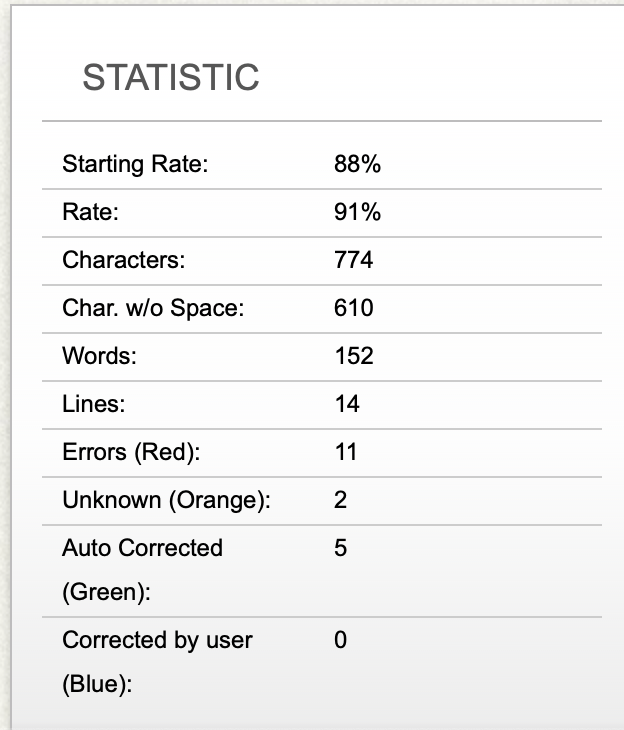

In [ ]:
#cleaner_text with 200 epochs
inp = input("Type a starting string: ")
print(generate_text(model, inp))

Type a starting string: I believe
I believe me. I'm so here, too. 
and now a while back. 
Before Ithere's owing its bright future full of becorn there. 
That is hospital is all hiding. 
I heard that everything about it spen the back of creation 
The mank you can talk to me! 
Ah! But, lo of 
I communications tower coming from Kagutsuchi made's probably will allow a life for not try that Nihilo terest is yourself, and they all that darkness 
while another demon has ever would it humans fined, but I don't tell just sin orry, but it lospital of the Vortex World. 
Well, line and sinker. 
There is a notice our god, Ahriman ong thered. 
There was a rumor! Hahahahahaha! 
We are things! 
I heard that must be since we gate. 
I am still our blood. 
My doubts is a war between two! 
We're guards know about the ulrise, it cannot be forgulayer, T


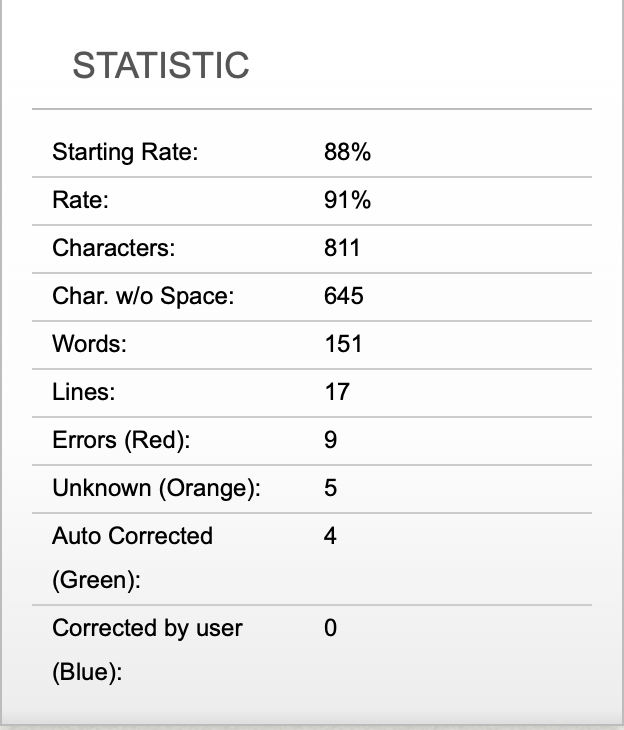

In [142]:
#with 500 epochs
inp = input("Type a starting string: ")
print(generate_text(model, inp))

Type a starting string: I believe
I believe that he did. 
This is the hole that the Manikin jumped into. 
You may be wrp under them. 
Those Mantra guys beat the hell outta this place. 
Those damn angels are all in a panic. Heheh. 
Those damn angel if you don't know the rules. So, here 
I heard something next door is closed tight. 
The child do we do n that one must wake up from a long sleep and face the barren world. 
Wariginal places and come here once again, 
If you can win, I'll give you all my money if you demons with your battles by some deadly virus 
This place has become desolate now. 
That hot chick is humans. 
I'm occuauld you three assistance 
So, was the report about needing to unlock the corelieve Reason 
The Collector Manikin is near a human. 
There is a ferocious dog blocking the path! 
That guy Forneus thinking, so I


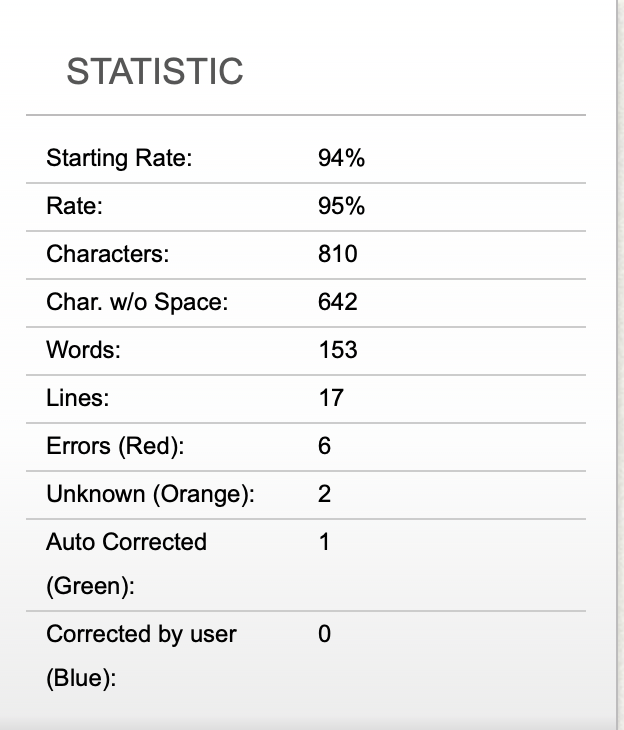
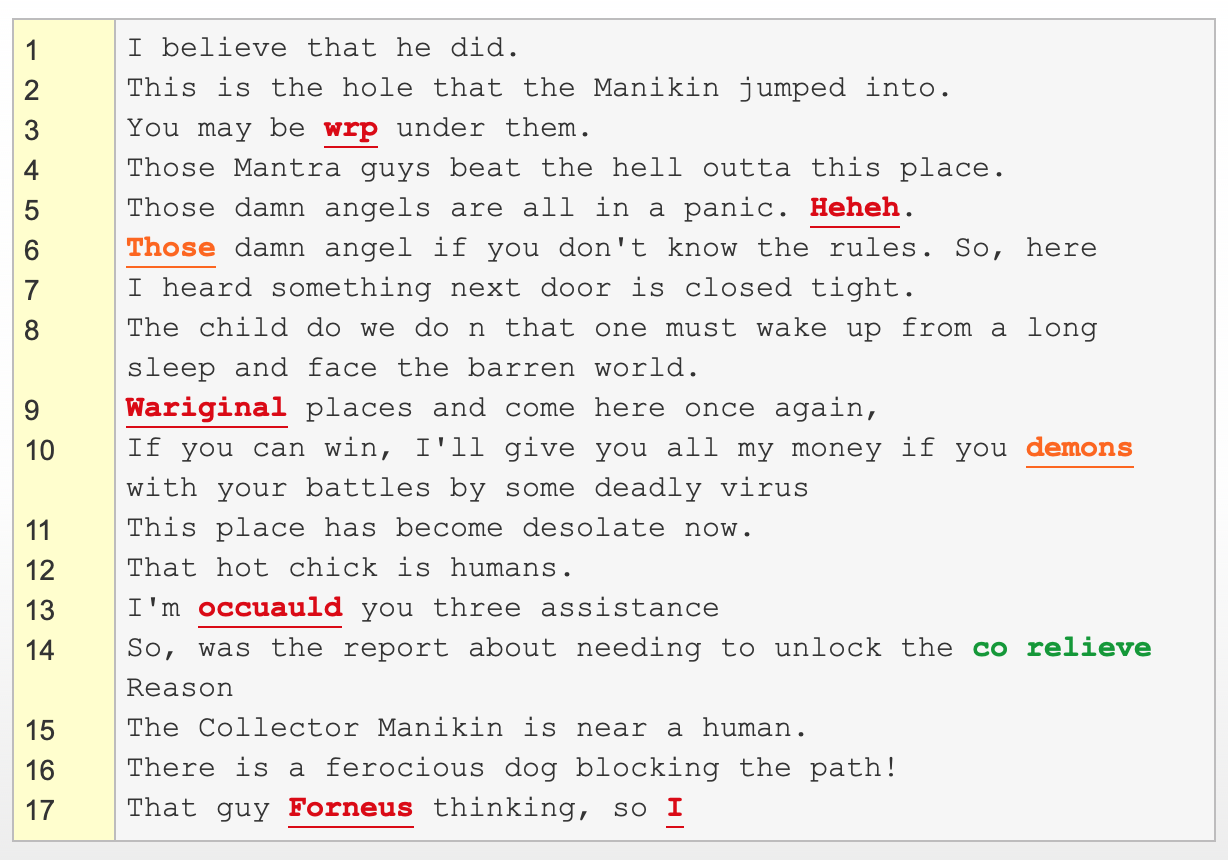

## It starts off great!...
## However, it degrades later.
## It will (POSSIBLY) work far better when it's trained with further epochs. Or perhaps with a single characters speech

#### Future plans
 - Generate only a sentence (2-3)
 - Connect our output into Wit.ai (sentament analysis)
 - Does our generated text convey the subject?
 - Can we perform spellcheck?
 - Trash bad output, and begin again